# The Data

Temperature and energy demand data (MW) for the City of Toronto for the last 2 years... scraped by me!

In [1]:
import pandas as pd

df = pd.read_csv('data/weather_power.csv')

In [2]:
df.head()

,date,temperature,energy_demand
0,2018-01-01 00:00:00,-16.9,5340
1,2018-01-01 01:00:00,-16.3,5211
2,2018-01-01 02:00:00,-17.6,5096
3,2018-01-01 03:00:00,-18.6,4987
4,2018-01-01 04:00:00,-17.8,4926


# Model 01

Select and split... let's just use temperature for now (dates are a little bit more complicated):

In [3]:
from sklearn.model_selection import train_test_split

target = 'energy_demand'
y = df[target]
X = df[['temperature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

> Max's Tip: you should try to get to a number as quickly as possible

To get to a number ASAP (ie: a score to beat) we'll use [`DummyRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html):

In [4]:
from sklearn.dummy import DummyRegressor
model = DummyRegressor()
model.fit(X_train, y_train)

DummyRegressor()

`DummyRegressor` will literally just predict the average for everything... doesn't matter what you put in:

In [5]:
model.predict(X_test)

array([5692.04161844, 5692.04161844, 5692.04161844, ..., 5692.04161844,
       5692.04161844, 5692.04161844])

You can confirm this by running:

In [6]:
y_train.mean()

5692.041618441358

But now we have a model that we can score so that we know what to beat:

In [7]:
from sklearn.metrics import mean_squared_error

round(mean_squared_error(y_test, model.predict(X_test)) ** (1/2))

1451.0

Given that Toronto on an average day uses ~5700 MW of electricity having our model be off by ~1400 MW isn't super great! But it's a start! We're going work on continously improving this number.

To run a prediction for a single row, or new entry, I like to send a row to a dictionary to get a sense of structure:

In [8]:
X.sample(1).to_dict(orient='list')

{'temperature': [-6.2]}

And then embed the output in a new pandas.DataFrame:

In [9]:
new = pd.DataFrame({'temperature': [21]})
model.predict(new)[0]

5692.041618441358

We're going to stuff new temperatures in our app into a pandas DataFrame exactly like that. But let's save the model so that we can wrap an app around it:

In [10]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

Before moving on to building the app, let's make sure it works:

In [11]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

model.predict(new)[0]

5692.041618441358

# App 01

Now that we have a "model" (granted it's pretty dumb!) it's time to stick it behind an app. 

To start our app is just going to be a shitty hello world Flask app:

In [12]:
%%writefile app.py

from flask import Flask

app = Flask(__name__)

@app.route('/')
def index():
    return 'Hello World!'

if __name__ == '__main__':
    app.run(port=5000, debug=True)

Writing app.py


Preview the app by running it from the command line:

```
python app.py
```

And visiting: http://127.0.0.1:5000/ 

Interrupt the process (ctrl+c) to kill the app and move on...

# App 02

Now that we have some boilerplate in place, we can extend the hello world example to include the model. While this looks like it might work, we're going to run it anyways...

In [13]:
%%writefile app.py

import pickle

from flask import Flask
import pandas as pd

app = Flask(__name__)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

@app.route('/')
def index():
    new = pd.DataFrame({'temperature': [20]})
    prediction = model.predict(new)
    print(prediction)
    return prediction

if __name__ == '__main__':
    app.run(port=5000, debug=True)

Overwriting app.py


Again, fire up the app at the command line the app at the command line:

```
python app.py
```

This time when you visit http://127.0.0.1:5000/ you'll get a:

**TypeError** 

> TypeError: The view function did not return a valid response. The return type must be a string, dict, tuple, Response instance, or WSGI callable, but it was a ndarray.  

Interrupt the process so that we can work on a fix.

# App 03

The TypeError helpful suggested that we could return a dictionary and it would work... let's do that now:

In [14]:
%%writefile app.py

import pickle
from flask import Flask
import pandas as pd

app = Flask(__name__)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

@app.route('/')
def index():
    new = pd.DataFrame({'temperature': [20]})
    prediction = model.predict(new)[0]
    # return str(prediction)
    return {'prediction': prediction}

if __name__ == '__main__':
    app.run(port=5000, debug=True)

Overwriting app.py


Alternatively, we could `return str(prediction)`. 

But let's run the app at the command line and preview it once more. This time you should see the dictonary return.

# App 04

You'll notice that while our model is embedded in our app it's just returning the prediction temperature=20 on every single request.

To make our app dynamic, we'll use "query params"... they look like:

`http://website.com/endpoint?query=string`

Query params will allow us to accept different inputs and pass them to our model via a pandas DataFrame... In order to capture query params, though, we need to import `flask.request` so that we can peel off dictionary keys from the `request.args` object...

As we do this, let's rejig the app to have a separate temperature endpoint:

In [15]:
%%writefile app.py

import pickle
from flask import Flask, request
import pandas as pd

app = Flask(__name__)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

@app.route('/')
def index():
    return 'Use the /predict endpoint'

@app.route('/predict')
def predict():
    query = request.args
    print(query)
    new = pd.DataFrame({'temperature': [20]})
    prediction = model.predict(new)[0]
    return {'prediction': prediction}

if __name__ == '__main__':
    app.run(port=5000, debug=True)

Overwriting app.py


Run the app and watch the command line when you hit it with different query strings like this:
    
- http://127.0.0.1:5000/predict?hi=there&name=max
- http://127.0.0.1:5000/predict?even=more&query=strings
- http://127.0.0.1:5000/predict?temperature=25

You should see something like `ImmutableMultiDict([('hi', 'there'), ('name', 'max')])` print to the console. Don't worry it's basically just a dictionary...

# App 05 

To *actually* connect the temperature query string to the model, let's grab it off `request.args` and format it as a float:

In [16]:
%%writefile app.py

import pickle
from flask import Flask, request
import pandas as pd

app = Flask(__name__)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

@app.route('/')
def index():
    return 'Use the /predict endpoint'

@app.route('/predict')
def predict():
    query = request.args
    temperature = float(query.get('temperature'))
    print(temperature)
    new = pd.DataFrame({'temperature': [temperature]})
    prediction = model.predict(new)[0]
    return {'prediction': prediction}

if __name__ == '__main__':
    app.run(port=5000, debug=True)

Overwriting app.py


Preview the app at the command line and hit the url with some temperatures:

- http://127.0.0.1:5000/predict?temperature=25
- http://127.0.0.1:5000/predict?temperature=-10
- http://127.0.0.1:5000/predict?temperature=5

You'll notice that the print statement in the console is registering the different values, but the model is just returning the same thing.

Well, that shouldn't surprise, model is dumb! Let's fix the dummy model we started with right now...

# Model 02

The `DummyRegressor` helped us quickly build an app, and gave us a number (in the form of RMSE) to beat, let's see if we can beat it with `LinearRegression`:

In [17]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Unfortunately, this breaks because our data has some NaNs in the temperature column:

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23040 entries, 0 to 23039
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           23040 non-null  object 
 1   temperature    22873 non-null  float64
 2   energy_demand  23040 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 540.1+ KB


# Model 03

Not to worry, dealing with NaNs is a cinch with `DataFrameMapper` from [sklearn-pandas](https://github.com/scikit-learn-contrib/sklearn-pandas) (basically my secret weapon/super power).

DataFrameMapper accepts a list of tuples, where each tuple identifies the column name and then the transformer that operates on it:

In [19]:
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([
    ('temperature', SimpleImputer())
], df_out=True)

While it works as a first class scikit-learn transformer (complete with `fit`, `transform`, and `fit_transform`) it comes with all of scikit-learns finickiness:

In [20]:
mapper.fit_transform(X_train)

ValueError: temperature: Expected 2D array, got 1D array instead:
array=[-16.9 -16.3 -17.6 ...   9.1   8.7   8.3].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

The above hits a **Value Error**

> ValueError: temperature: Expected 2D array, got 1D array instead:

Because of how scikit-learn is designed. Without going into the nitty-gritty, this error has to do with the difference between how scikit-learn handles strings and numbers and columns and series.

Not to worry, errors like this in DataFrameMapper are easily fixed by wrapping the pesky column in square brackets:

In [21]:
mapper = DataFrameMapper([
    (['temperature'], SimpleImputer())
], df_out=True)

mapper.fit_transform(X_train)

,temperature
0,-16.9
1,-16.3
2,-17.6
3,-18.6
4,-17.8
...,...
20731,10.3
20732,9.5
20733,9.1
20734,8.7


# Model 04

Using the DataFrameMapper, we can now transform our `X` objects to intermediate `Z` objects... 

> Max's Tip: You could just overwrite the `X`s but I like `Z`s becauxe they remind me "HEY I DID SOMETHING TO THIS!~"

In [22]:
Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test)

model = LinearRegression()
model.fit(Z_train, y_train)

LinearRegression()

Now let's score the model again:

In [23]:
round(mean_squared_error(y_test, model.predict(Z_test)) ** (1/2))

1345.0

And notice that this new model beats the dummy, albeit by not much. 

Peeking at some examples we can see that it's still pretty constrained around the mean:

In [25]:
pd.DataFrame({
    'y_true': y_test,
    'y_hat': model.predict(Z_test)
}).sample(10)

,y_true,y_hat
22211,7358,5926.583433
21302,5910,5925.108093
21171,3835,5724.461788
21114,5782,5821.834260
21492,4798,5811.506876
22571,8060,5959.040924
21585,6435,5917.731390
22591,6236,5860.193112
22154,4701,5874.946517
21276,7419,5935.435476


# Model 05

While our model still isn't amazing, it is an improvement, and a little more dynamic, so let's  "serialize" the mapper and model:

In [26]:
with open('mapper.pkl', 'wb') as f:
    pickle.dump(mapper, f)
    
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

But, wait up, this isn't super ideal because in this paradigm we have to keep track of and load two separate things:

In [28]:
with open('mapper.pkl', 'rb') as f:
    mapper = pickle.load(f)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

And in order to predict we need to remember to transform first:

In [29]:
new = pd.DataFrame({'temperature': [21]})

Z_new = mapper.transform(new)
model.predict(Z_new)[0]

5879.372538053129

We can actually make things a little more simple...

# Model 06

Enter pipelines... a scikit-learn tool that will ensure that we only have to manage one thing!

And, as an added bonus, using pipeline will make it so that we can get rid of the intermediate `Z` objects at the same time!

In [30]:
from sklearn.pipeline import make_pipeline

In [31]:
pipe = make_pipeline(mapper, model)
pipe.fit(X_train, y_train);

Now we only have to dump one thing:

In [32]:
with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

And load one object:

In [ ]:
with open('pipe.pkl', 'rb') as f:
    pipe = pickle.load(f)

Predictions don't require transformation now (because it happens inside the pipeline): 

In [35]:
pipe.predict(new)[0]

5879.372538053129

In order to deploy this new pipeline model let's wrap everything into a single file...

In [36]:
%%writefile model.py

import pickle
import pandas as pd
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

df = pd.read_csv('data/weather_power.csv')

target = 'energy_demand'
y = df[target]
X = df[['temperature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

mapper = DataFrameMapper([
    (['temperature'], SimpleImputer())
], df_out=True)

model = LinearRegression()

pipe = make_pipeline(mapper, model)
pipe.fit(X_train, y_train)

with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

Writing model.py


# Deploy 01 - Heroku

We're going to deploy our model and app on Heroku. In order to do that, follow these simple steps:

1. Setup a virtual environment:

```
python -m venv .venv
```

2. Activate it:

```
source .venv/bin/activate
```

3. Install the app and model dependencies (`gunicorn` something that will sit between heroku and our app...):

```
pip install gunicorn flask scikit-learn pandas sklearn_pandas
```

3. Freeze the dependencies:

```
pip freeze > requirements.txt
```

4. Retrain the model inside of the virtual environment:

```
python model.py
```

5. Make sure the app still works locally:

```
python app.py
```

6. Specify a python runtime (3.8 not working yet):

```
python --version
echo "python-3.7.9" > runtime.txt
```

7. Create a `Procfile`:

```
echo "web: gunicorn app:app" > Procfile
```

8. (Optional) If your project isn't already a git repo, make it one:

```
git init
touch .gitignore
echo ".venv" >> .gitignore
```

9. Login to Heroku from the [command line](https://devcenter.heroku.com/articles/heroku-cli):

```
heroku login
```

10. Create a project:

```
heroku create
```

11. Add a remote to the randomly generated project:

```
heroku git:remote -a silly-words-009900
```

12. Test the app locally:

```
heroku local
```

13. add, commit push:

```
git add .
git commit -m '🚀'
git push heroku
```

14. Hit the url and make sure it works!

- http://\<url\>/predict?temperature=20

15. Make sure nothing is wrong (check the logs!):

```
heroku logs -t 
```

# App 07

Well! We have an app deployed. And it's working... but now it's time to level-up. Starting with the actual app. 

Flask is old news....

FastAPI is the new kid on the block. It's faster, less boilerplate, and the future. And converting from Flask to FastAPI isn't that tough:

In [37]:
%%writefile app.py

import pickle
import pandas as pd

import uvicorn
from fastapi import FastAPI

app = FastAPI()

with open('pipe.pkl', 'rb') as f:
    pipe = pickle.load(f)

@app.get('/')
def index():
    return 'Use the /predict endpoint with a temperature argument'

@app.get('/predict')
def predict(temperature: float):
    new = pd.DataFrame({'temperature': [temperature]})
    prediction = pipe.predict(new)[0]
    return {'prediction': prediction}

if __name__ == '__main__':
    uvicorn.run(app)

Overwriting app.py


The main differences, `route`s are now `get`s and we can specify types in the endpoint functions!

To run this fastAPI at the command line use:

```
uvicorn app:app --port 5000 --reload
```

> Tip: The first app in `app:app` is the file name, and the second app is the name of the app inside the file. These can be whatever!

Try it out and make sure it still works:

- http://127.0.0.1:5000/predict?temperature=20

As a bonus there's also some wicked auto-generate docs at:

- http://127.0.0.1:5000/docs

Kill the app once you've verified it works to move on...

# Deploy 02

To deploy fastAPI to Heroku isn't much more work because we already have an environment setup.

0. If you're not in your environment anymore you can re-enter with:

```
source .venv/bin/activate

# don't do it now, but to exit the environment you can call:
deactivate
```

1. Install the new dependencies:

```
pip install uvicorn fastapi
```

2. Freeze the dependencies:

```
pip freeze > requirements.txt
```

3. Retrain the model inside the virtual environment:

```
python model.py
```

4. Make sure the app still works locally:

```
uvicorn app:app --port=5000
```

5. Create a new `Procfile`:

```
echo 'web: uvicorn app:app --host=0.0.0.0 --port=${PORT:-5000}' > Procfile
```

6. Test the app locally:

```
heroku local
```

7. add, commit push:

```
git add .
git commit -m '🚀'
git push heroku
```

8. Click on the url and make sure it works!

- http://\<url\>/predict?temperature=20

# Model 07

We upgraded our app, but our model is still stuck in the dark ages...

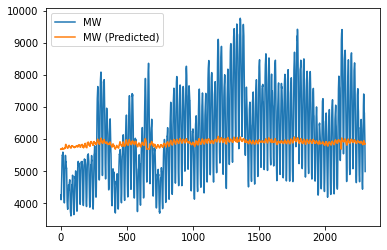

In [41]:
from matplotlib import pyplot as plt

plt.plot(range(len(y_test)), y_test, label='MW')
plt.plot(range(len(y_test)), model.predict(Z_test), label='MW (Predicted)')
plt.legend();

It barely explains anything!

But temperature should be able to explain a lot (as it pertains to energy demand):

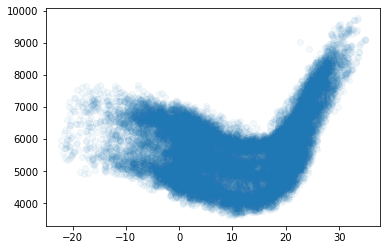

In [42]:
plt.scatter(df['temperature'], df['energy_demand'], alpha=1/20);

The problem is, temperature and energy demand isn't linear. When it's cold, we heat our homes, and when it's hot, we cool our homes! Temperature has a parabolic relationship to energy!

Whenever we see a "U" or a rainbow, we should think `PolynomialFeatures`. Adding Poly to our pipeline is a matter of slightly adjusting the DataFrameMapper:

In [43]:
from sklearn.preprocessing import PolynomialFeatures

mapper = DataFrameMapper([
    (['temperature'], [SimpleImputer(), PolynomialFeatures(degree=2, include_bias=False)])
], df_out=True)

mapper.fit_transform(X_train)

,temperature_x0,temperature_x0^2
0,-16.9,285.61
1,-16.3,265.69
2,-17.6,309.76
3,-18.6,345.96
4,-17.8,316.84
...,...,...
20731,10.3,106.09
20732,9.5,90.25
20733,9.1,82.81
20734,8.7,75.69


In a full pipeline it looks like this:

In [46]:
pipe = make_pipeline(mapper, model)
pipe.fit(X_train, y_train)

Pipeline(steps=[('dataframemapper',
                 DataFrameMapper(df_out=True,
                                 features=[(['temperature'],
                                            [SimpleImputer(),
                                             PolynomialFeatures(include_bias=False)])])),
                ('linearregression', LinearRegression())])

And this time our model scores:

In [47]:
round(mean_squared_error(y_test, pipe.predict(X_test)) ** (1/2))

927.0

And explains over half of the variance in energy demand:

In [49]:
pipe.score(X_test, y_test)

0.5550072850130577

We should be pretty excited. While we still have a lot of work to do, let's wrap this modified code into a `model.py` file so that we can redeploy!

In [50]:
%%writefile model.py

import pickle
import pandas as pd
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_csv('data/weather_power.csv')

target = 'energy_demand'
y = df[target]
X = df[['temperature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

mapper = DataFrameMapper([
    (['temperature'], [SimpleImputer(), PolynomialFeatures(degree=2, include_bias=False)])
], df_out=True)

model = LinearRegression()
pipe = make_pipeline(mapper, model)
pipe.fit(X_train, y_train)

with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

Overwriting model.py


# Deploy 03

As no dependencies have changed, it's going to be a lot easier to push a change, just...

1. Retrain the model inside of the virtual environment:

```
python model.py
```

2. Test the app locally:

```
heroku local
```

3. Try a bucnch of different temperatures:

- http://0.0.0.0:5000/predict?temperature=30
- http://0.0.0.0:5000/predict?temperature=21
- http://0.0.0.0:5000/predict?temperature=-10

4. Kill the app to move on...

5. add, commit push:

```
git add .
git commit -m '🚀'
git push heroku
```

6. Click on the url and make sure it works!

- http://\<url\>/predict?temperature=20

# Model 08 

Right now our model is just using temperature, and although it does alright:

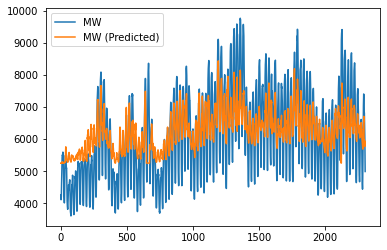

In [54]:
plt.plot(range(len(y_test)), y_test, label='MW')
plt.plot(range(len(y_test)), pipe.predict(X_test), label='MW (Predicted)')
plt.legend();

We can do better. We have a date column with timestamps! There has to be some good single in there. To get at it let's first convert the date column from a string to a date:

In [55]:
df['date'] = pd.to_datetime(df['date'])

Alternatively, we can parse the date column (0th position) on import, which is actually prefered:

In [56]:
df = pd.read_csv('data/weather_power.csv', parse_dates=[0])

The most interest and easiest date signals to capture are month, weekday and hour:

In [57]:
col = df['date']

pd.concat([col.dt.month, col.dt.weekday, col.dt.hour], axis=1)

,date,date,date
0,1,0,0
1,1,0,1
2,1,0,2
3,1,0,3
4,1,0,4
...,...,...,...
23035,8,0,19
23036,8,0,20
23037,8,0,21
23038,8,0,22


To embed these new signals in our app let's recut our `X`s and `y`s:

In [58]:
target = 'energy_demand'
y = df[target]
X = df[['date', 'temperature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

And build a scikit-learn transformer to handle the date features for us:

In [59]:
from sklearn.base import TransformerMixin

class DateEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.concat([X.dt.month, X.dt.weekday, X.dt.hour], axis=1)

This way we can apply it on the `X_train` and `X_test` objects:

In [60]:
DateEncoder().fit_transform(X_train['date'])

,date,date,date
0,1,0,0
1,1,0,1
2,1,0,2
3,1,0,3
4,1,0,4
...,...,...,...
20731,5,2,19
20732,5,2,20
20733,5,2,21
20734,5,2,22


And easily embed it in our mapper framework:

In [61]:
mapper = DataFrameMapper([
    ('date', DateEncoder(), {'input_df': True}),
    (['temperature'], [SimpleImputer(), PolynomialFeatures(degree=2, include_bias=False)])
], df_out=True)

model = LinearRegression()
pipe = make_pipeline(mapper, model)
pipe.fit(X_train, y_train)

Pipeline(steps=[('dataframemapper',
                 DataFrameMapper(df_out=True,
                                 features=[('date',
                                            {'input_df': True}),
                                           (['temperature'],
                                            [SimpleImputer(),
                                             PolynomialFeatures(include_bias=False)])])),
                ('linearregression', LinearRegression())])

This new model shaves even more off our RMSE score (remember how we started off by ~1400 MW!!):

In [62]:
mean_squared_error(y_test, pipe.predict(X_test)) ** (1/2)

801.8078829389401

And explains even more variance:

In [63]:
pipe.score(X_test, y_test)

0.667215461044525

The prediction plot shows that dates signals really helped:

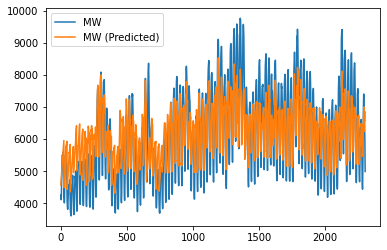

In [65]:
plt.plot(range(len(y_test)), y_test, label='MW')
plt.plot(range(len(y_test)), pipe.predict(X_test), label='MW (Predicted)')
plt.legend();

Unfortunately, because of how pickle works, we have move the `DateEncoder` to a `utils.py` file (and import it separately in our app... bummer, I know):

In [66]:
%%writefile utils.py

import pandas as pd
from sklearn.base import TransformerMixin

class DateEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.concat([X.dt.month, X.dt.weekday, X.dt.hour], axis=1)

Overwriting utils.py


The full working model should be written to a new `model.py` file so that we can can retrain within our environment:

In [67]:
%%writefile model.py

import pickle
import pandas as pd
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from utils import DateEncoder # CUSTOM MODULE IMPORT

df = pd.read_csv('data/weather_power.csv', parse_dates=[0])

target = 'energy_demand'
y = df[target]
X = df[['date', 'temperature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

mapper = DataFrameMapper([
    ('date', DateEncoder(), {'input_df': True}),
    (['temperature'], [SimpleImputer(), PolynomialFeatures(degree=2, include_bias=False)])
], df_out=True)

model = LinearRegression()
pipe = make_pipeline(mapper, model)
pipe.fit(X_train, y_train)

with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

Overwriting model.py


# App 08

To integrate this new model into our fastAPI app, add the custom `DateEncoder` import and and adjust the index endpoint function to accept a dictionary.

Might as well make it post request at the same time!

In [68]:
%%writefile app.py

import pickle
import pandas as pd
import uvicorn
from fastapi import FastAPI
from typing import Dict
import os
from utils import DateEncoder

app = FastAPI()

with open('pipe.pkl', 'rb') as f:
    pipe = pickle.load(f)

@app.post('/')
def index(json_data: Dict):
    new = pd.DataFrame({
        'date': [pd.Timestamp(json_data.get('date'))],
        'temperature': [float(json_data.get('temperature'))]
    })
    prediction = pipe.predict(new)[0]
    return {'prediction': prediction}

if __name__ == '__main__':
    uvicorn.run(app)

Overwriting app.py


# Post Carrier Function

Converting our app from GET to POST requests, means that we lose the query string paradigm. In order to interoperate with this new app, we'll need a function to send data to the endpoint and parse the response. This is what I use:

In [69]:
import json
from urllib.request import Request, urlopen
import pandas as pd

def post(url, data):
    data = bytes(json.dumps(data).encode("utf-8"))
    request = Request(
        url=url,
        data=data,
        method="POST"
    )
    request.add_header("Content-type", "application/json; charset=UTF-8")
    with urlopen(request) as response:
        data = json.loads(response.read().decode("utf-8"))
    return data

# Deploy 04

While Heroku is great. It's expensive, and sleeps after awhile. It's time to graduate to Dokku (a Heroku Open Source alternative, and overall just way better). Deploying to Dokku is a little more involved but I promise it's worth it!

Rerun the model:

```
python model.py
```

Make sure it still works locally:

```
uvicorn app:app --port 5000 --reload
```

And our new "post carrier" function to test:

In [70]:
data = {
    "date": str(pd.Timestamp('now')),
    "temperature": 25
}

In [71]:
post("http://127.0.0.1:5000", data)

{'prediction': 6339.911775618921}

Once you've confirmed that it still works, let's get working on Dokku.

My deploy Dokku to setup:

1. Sign up for a [DigitalOcean](https://m.do.co/c/2909cd1f3f10) account

2. Spin up a $5 Ubuntu 20/18.04 server...

3. ssh into it:

```
ssh root@142.XXX.153.207
```

4. (Strongly advised) Update everything:

```
sudo apt update
sudo apt -y upgrade
```

5. Setup a firewall:

````
ufw app list
ufw allow OpenSSH
ufw enable
````

6. Add some rules ([source](https://www.digitalocean.com/community/tutorials/how-to-set-up-a-firewall-with-ufw-on-ubuntu-18-04)):

```
sudo ufw default deny incoming
sudo ufw default allow outgoing
sudo ufw allow ssh
sudo ufw allow 22
sudo ufw allow http
sudo ufw allow https
```

7. Install dokku (be patient... takes about 5 minutes):

```
wget https://raw.githubusercontent.com/dokku/dokku/v0.21.4/bootstrap.sh
sudo DOKKU_TAG=v0.21.4 bash bootstrap.sh
```

**THIS STEP IS IMPORTANT!**

8. Visit the Droplet’s IP address in a browser to finish configuring Dokku


9. Copy and paste your ssh key from your **laptop** into the config window:

```
cat .ssh/id_rsa.pub
```

10. And add the IP of the server to the hostname:

`142.XXX.153.207`


11. Click "Finish Setup"...


12. Go back to the server terminal and create a dokku app on the server (I'm calling this one `powerapp`):

```
dokku apps:create powerapp
dokku domains:enable powerapp

```

**On Laptop**

12. Add dokku as a remote:

```
git remote add dokku dokku@142.XXX.153.207:powerapp
```

13. Verify that the remote got added:

```
git remote -v
```

14. Push it up (for every new change just run these commands):

```
git add .
git commit -m '🤞'
git push dokku
```

15. Test if it works with the post function:

In [ ]:
post("http://142.93.153.207", data)

# Model 09

Add some tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

mapper = DataFrameMapper([
    ('date', DateEncoder(), {'input_df': True}),
    (['temperature'], [SimpleImputer(), PolynomialFeatures(degree=2, include_bias=False)])
], df_out=True)

Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test)

model = Sequential()
model.add(Input(shape=(Z_train.shape[1],)))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.fit(
    Z_train, y_train,
    epochs=100, batch_size=32,
    validation_data=(Z_test, y_test)
)

model.evaluate(Z_test, y_test)
r2_score(y_test, model.predict(Z_test)), r2_score(y_test, model.predict(Z_test))

Predict something new:

In [ ]:
new = pd.DataFrame({
    'date': [pd.Timestamp('now')],
    'temperature': [17]
})

model.predict(mapper.transform(new))[0][0]

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(X_test['date'], y_test, alpha=1/2);
plt.plot(X_test['date'], model.predict(Z_test).flatten(), alpha=1/2);

round(mean_squared_error(y_test, model.predict(Z_test)) ** (1/2))

# Model 10

Use a KerasRegressor Wrapper and a SelectKBest:

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model
from sklearn.feature_selection import SelectKBest

Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test)

columns = 5
select = SelectKBest(k=columns)

select.fit_transform(Z_train, y_train)

def nn():
    columns = 5
    m = Sequential()
    m.add(Input(shape=(columns,)))
    m.add(Dense(10, activation='relu'))
    m.add(Dense(10, activation='relu'))
    m.add(Dense(1))
    m.compile(
        loss='mean_squared_error',
        optimizer='adam',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return m

model = KerasRegressor(nn, epochs=100, batch_size=32, verbose=0)

See how the pipe can work:

In [ ]:
pipe = make_pipeline(mapper, select, model)
pipe.fit(X_train, y_train)

new = pd.DataFrame({
    'date': [pd.Timestamp('now')],
    'temperature': [17]
})

float(pipe.predict(new))

Serializing is going to be a bit of a headache, need to dump the model first then pickle the pipeline:

In [ ]:
pipe.named_steps['kerasregressor'].model.save('model.h5')
pipe.named_steps['kerasregressor'].model = None

In [ ]:
with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

Loading it back in looks like this:

In [ ]:
with open('pipe.pkl', 'rb') as f:
    pipe = pickle.load(f)

pipe.named_steps['kerasregressor'].model = load_model('model.h5')

float(pipe.predict(new))

Should move the `nn` definition to utils:

In [ ]:
%%writefile utils.py

import pandas as pd
from sklearn.base import TransformerMixin
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

class DateEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.concat([X.dt.month, X.dt.weekday, X.dt.hour], axis=1)
    
def nn():
    columns = 5
    m = Sequential()
    m.add(Input(shape=(columns,)))
    m.add(Dense(10, activation='relu'))
    m.add(Dense(10, activation='relu'))
    m.add(Dense(1))
    m.compile(
        loss='mean_squared_error',
        optimizer='adam',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return m

Write the full model:

In [ ]:
%%writefile model.py

import pickle
import pandas as pd
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model

from utils import DateEncoder, nn

df = pd.read_csv('data/weather_power.csv', parse_dates=[0])

target = 'energy_demand'
y = df[target]
X = df[['date', 'temperature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

mapper = DataFrameMapper([
    ('date', DateEncoder(), {'input_df': True}),
    (['temperature'], [SimpleImputer(), PolynomialFeatures(degree=2, include_bias=False)])
], df_out=True)

columns = 5
select = SelectKBest(k=columns)

model = KerasRegressor(nn, epochs=100, batch_size=32, verbose=0)

pipe = make_pipeline(mapper, select, model)
pipe.fit(X_train, y_train)

pipe.named_steps['kerasregressor'].model.save('model.h5')
pipe.named_steps['kerasregressor'].model = None

with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

# App 10

Add the tensorflow model and async and RequestData:

In [ ]:
%%writefile app.py

import os
import pickle

from fastapi import FastAPI
import uvicorn
from typing import Dict
from pydantic import BaseModel

import pandas as pd
from tensorflow.keras.models import load_model
from utils import DateEncoder, nn

app = FastAPI()

with open('pipe.pkl', 'rb') as f:
    pipe = pickle.load(f)

pipe.named_steps['kerasregressor'].model = load_model('model.h5')

class RequestData(BaseModel):
    date: str
    temperature: float

@app.post('/')
async def index(request: RequestData): # add async and RequestData
    new = pd.DataFrame({
        'date': [pd.Timestamp(request.date)],
        'temperature': [request.temperature]
    })
    prediction = float(pipe.predict(new))
    return {'prediction': prediction}

if __name__ == '__main__':
    uvicorn.run(app)

# Deploy 5

1. Update environment:

```
pip install tensorflow
```

2. Freeze the dependencies:

```
pip freeze > requirements.txt
```

3. Retrain the model inside of the virtual environment:

```
python model.py
```

4. Make sure the app still works locally:

```
uvicorn app:app --port 5000 --reload
```

5. Push everything up to GitHub:

```
git add .
git commit -m '🚀'
git push dokku
```

6. Check logs on server (to make sure it all works)

```
dokku logs powerapp --tail
```

7. Test with the post function:

In [ ]:
data = {
    "date": str(pd.Timestamp('now')),
    "temperature": 20
}

post("http://142.93.148.110", data)

And that's it!

New changes that don't have any new depends will just need:

```
git add .
git commit -m '🚀'
git push dokku
```